In [1]:
##Importing libraries
import langchain
import cv2
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import base64
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
import matplotlib.pyplot as plt
import numpy as np
import sys
from PIL import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from utils import * 
%matplotlib inline

In [26]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
   background-color: transparent !important;
}

/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=2000,
    timeout=None,
    max_retries=2,
)

In [4]:
with open('system_prompt.txt','r') as prompt_file:
    system_prompt = prompt_file.read()
print(system_prompt)

You are an experienced english writer. You will be provided with real life photographs.
Your task is to write a narrative poem based on the photograph provided to you.
The poem should tell a story featuring the subject/subjects or landscape present in the photograph.
The poem should be simple, easy to understand and meaningful.
The poem should be set in past tense.
The poem should have an inspirational, warm and happy tone.
The poem should not be longer than 2 sentences.


In [5]:
prompt = ChatPromptTemplate.from_messages(
    [
    ("system", "{system_prompt}"),
    ("user",
     [
         {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{base64_image}"},
          }
      ]
    )
])

parser = StrOutputParser()

chain = prompt | llm |parser

In [9]:
## Single Image Run
@interact_manual
def run_single_image(image_file_name=widgets.Dropdown(options=get_file_names('images'),style={'description_width':'initial'})):
    res_dict = genrate_caption(chain=chain,system_prompt=system_prompt,image_file_name=image_file_name)
    display_results(final_results_dict=res_dict)

interactive(children=(Dropdown(description='image_file_name', options=('40522491730_088ca7a49c_o.jpg', 'DSC010…

In [11]:
## MultiImage Generation Loop
final_results_dict = {}
for image in get_file_names('images')[5:7]:
    res_dict = genrate_caption(chain=chain,system_prompt=system_prompt,image_file_name=image)
    final_results_dict.update(res_dict)

images/DSC03230.jpg resized


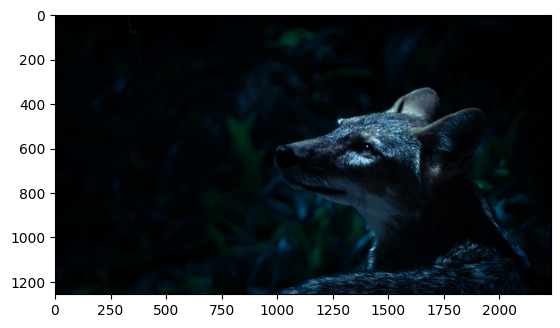

In the shadows of the forest deep,  
A watchful spirit stirred from sleep.  


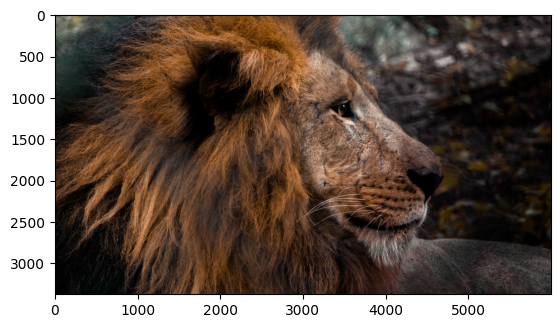

In the golden glow of the setting sun, a lion once roamed with a regal grace,  
His mane a crown of wild dreams, whispering tales of strength and a fierce embrace.


In [12]:
display_results(final_results_dict=final_results_dict)

In [13]:
regenerate_prompt = ChatPromptTemplate.from_messages(
    [
    ("system", "{system_prompt}"),
    ("user",
     [
         {
             "type":"text",
             "text":"You generated the following output for the given image.\n {initial_output} \n. Regenerate a different and better output following your system instruction for the image given below."
             
         },
         {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{base64_image}"},
          }
      ]
    )
])

regenerate_chain = regenerate_prompt|llm|parser

In [15]:
@interact_manual
def f(d = widgets.SelectMultiple(options=final_results_dict.keys(),disabled=False,style={'description_width':'initial'},description='Select Image file:')):
    regen_dict = {k:v for (k,v) in final_results_dict.items() if k in d}
    regen_results = {}
    for k,v in regen_dict.items():
        res_dict = regenrate_caption(chain=regenerate_chain,system_prompt=system_prompt,image_file_name=k,initial_output=v)
        regen_results.update(res_dict)
        final_results_dict.update(regen_dict)
    display_results(regen_results)
    return regen_results

interactive(children=(SelectMultiple(description='Select Image file:', options=('DSC02807-3.jpg', 'DSC03230.jp…